## Preparation
---

In [14]:
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import yfinance as yf
import datetime
import os
import pdb
import threading
import queue

## Design the fucntion to run in threads with OOP
---

In [15]:
class ModelTrainer(threading.Thread):
    def __init__(self, num,  *args, x_train, y_train, x_test, y_test, scaler= None, num_cells_layer1, num_batch_size, num_epochs, errorQueue=None, modelQueue=None, lock=None):
        threading.Thread.__init__(self)
        self.x_train = x_train
        self.y_train = y_train
        self.num_cells_layer1 = num_cells_layer1
        self.num_batch_size = num_batch_size
        self.num_epochs = num_epochs
        self.errorQueue = errorQueue
        self.modelQueue = modelQueue
        self.lock = lock
        self.num = num
        self.x_test = x_test
        self.y_test = y_test
        self.scaler = scaler

    def run(self):
        #### Basically the below is the same as how we build, train, test a model in usual
        model = Sequential()

        j = self.x_train.shape[1]
        model.add(LSTM(self.num_cells_layer1,
                  return_sequences=False, input_shape=(j, 1)))
        model.add(Dense(25))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mean_squared_error')

        model.fit(self.x_train, self.y_train,
                  batch_size=self.num_batch_size, epochs=self.num_epochs)

        predictions = model.predict(self.x_test)

        if(self.scaler != None):
            predictions = self.scaler.inverse_transform(predictions)

        rmse = np.sqrt(np.mean((self.y_test - predictions)**2))


        #### Each model and its RMSE will be returned to the modelQueue in the main thread.
        self.lock.acquire()  ## Using lock to avoid errors in accessing the global queue 
        print(f"Lock acquired by {self.num }") 

        self.modelQueue.put(rmse)  ## pass the rmse
        self.modelQueue.put(model)  ## pass the mode
        self.modelQueue.put(int(self.num))  ## pass the num(i.e. ID) of the thread

        print(f"Lock acquired by {self.num}")
        self.lock.release()


## Define Constants for the Whole Process
---

In [16]:
## symbol of the target stock 
stock = "DHI"

## Parameters for the training approach
window_interval = 45
delay = 8  # i.e. the No. of future days that we can do prediction

## Hyperparameters for the Model
num_cells_layer1 = 40
num_cells_layer2 = None
num_batch_size = 2
num_epochs = 3

## Starting Date of the data to train
start_date = datetime.datetime(2008, 11, 17)

## number of models to generate
numOfModels = 10  ## also equals the number of threads that will be created later

## Feature Engineering
---
This part is all most the same as what we do before training a model

In [17]:
df = yf.download(stock, start=start_date)

data = df[['Close']]
dataset = data.values

## Get the length of training data
training_data_len = math.ceil(len(dataset)*0.8)   ## Ratio of Train and Test set is 8:2


## Scale the data by MinMax Method
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)


## Build Training Set
train_data = scaled_data[0:training_data_len]

x_train = []
y_train = []

for i in range(window_interval+delay, len(train_data)):
    x_train.append(train_data[i-window_interval-delay:i-delay, 0])
    y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
i, j = x_train.shape
x_train_reshaped = np.reshape(x_train, (i, j, 1))
x_train_reshaped.shape


## Build Test Set
test_data = scaled_data[training_data_len-window_interval:]
x_test = []
y_test = dataset[training_data_len:,]

for i in range(window_interval, len(test_data)):
    x_test.append(test_data[i-window_interval:i, 0])


x_test = np.array(x_test)
i, j = x_test.shape
x_test = np.reshape(x_test, (i, j, 1))

[*********************100%%**********************]  1 of 1 completed


## Model Training Process in Multiprocessing
---

In [18]:
## Create a queue and a lock for the multithreading system

modelQueue = queue.Queue()
lock = threading.Lock()

In [19]:
threadList = []
for i in range(numOfModels):
    threadList.append(ModelTrainer(i, x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test, num_cells_layer1=num_cells_layer1,
                                   num_batch_size=num_batch_size, num_epochs=num_epochs, errorQueue=None, modelQueue=modelQueue, lock=lock))

    threadList[i].start()

## Main Thread should stop and wait for all other threads to finish
for i in range(numOfModels):
    threadList[i].join()

Epoch 1/3
Epoch 1/3
Epoch 1/3
Epoch 1/3
Epoch 1/3
Epoch 1/3
Epoch 1/3
Epoch 1/3
Epoch 1/3
Epoch 1/3
1472/1472 [==============================] - 93s 51ms/step - loss: 7.7524e-04
Epoch 2/3
1472/1472 [==============================] - 94s 50ms/step - loss: 6.4010e-04
Epoch 2/3
1472/1472 [==============================] - 95s 50ms/step - loss: 7.6458e-04
Epoch 2/3
1472/1472 [==============================] - 96s 51ms/step - loss: 7.9242e-04
Epoch 2/3
1472/1472 [==============================] - 96s 51ms/step - loss: 5.6723e-04
Epoch 2/3
1472/1472 [==============================] - 95s 51ms/step - loss: 6.9966e-04
Epoch 2/3
1468/1472 [============================>.] - ETA: 0s - loss: 4.6062e-040

KeyboardInterrupt: 

## Organise the Objects in the Queue into a List
___

In [ ]:
## Put the info returned from i-th threads to modelList[i]
modelList = [0]*numOfModels
while modelQueue.qsize() > 0:
    tmpRMSE = modelQueue.get()
    tmpModel = modelQueue.get()
    index = modelQueue.get()
    modelList[index] = [tmpModel, tmpRMSE]

## Infact, it is not necessary to consider if the order of info is same as that of the threads.
## However, that will make the things clear

In [ ]:
## find out the index with the smallest value of RMSE
## Then, the model that fits the testing set the most could be figured out

modelList = np.array(modelList)
posMinError = np.argmin(modelList[:, 1])
best_model = modelList[posMinError, 0]

## Save the Selectd Model
---

In [ ]:
best_model.save(stock+'_model')

INFO:tensorflow:Assets written to: NVR_model/assets


INFO:tensorflow:Assets written to: NVR_model/assets


## Plot the Selected Model
---

35/35 [==============================] - 0s 9ms/step


/var/folders/0c/4yyxy27966j8h86h_vwsy3680000gn/T/ipykernel_13546/40509518.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = best_predictions


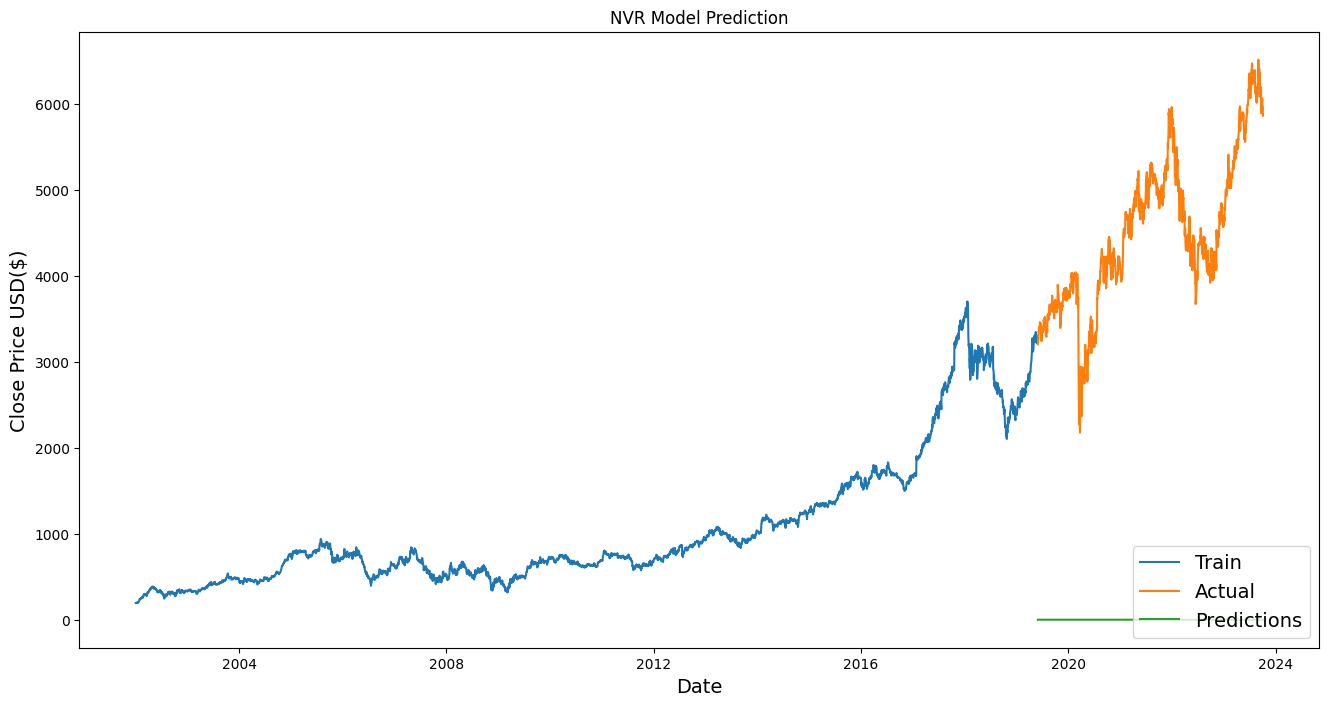

In [ ]:
best_predictions = best_model.predict(x_test)
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = best_predictions

plt.figure(figsize = (16,8))
plt.title(stock+' Model Prediction')
plt.xlabel('Date',fontsize = 14)
plt.ylabel('Close Price USD($)', fontsize = 14)
plt.plot(train['Close'])
plt.plot(valid['Close'])
plt.plot(valid['Predictions'])
plt.legend(['Train','Actual','Predictions'], loc = 'lower right', fontsize = 14)
plt.savefig(os.path.join(stock+'_model',"prediction.jpg"))